#Multivariate LSTM model

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mysql.connector
import matplotlib.pyplot as plt


Constructing the dataset

In [2]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="yahoonet",
    database="AIProject"
)

def make_multivariate_sequences(array, n_steps):
    """array shape: (timesteps, n_features)"""
    X, y = [], []
    for i in range(len(array)-n_steps):
        X.append(array[i:i+n_steps,:])      # n_steps x n_features
        y.append(array[i+n_steps,0])        # predict market_value next
    return np.array(X), np.array(y)

# --- Load the merged time series ---
# (Here df_t is the transfer history with date & market_value)
# (df_f is the player_features table with static columns)

df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
df_f = pd.read_sql("SELECT * FROM player_features", db)

# Merge static features onto each time row
df = df_t.merge(df_f[["player_id","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]],
                left_on="transfermarkt_id", right_on="player_id", how="left")

# Sort by time per player
df = df.sort_values(["transfermarkt_id","transfer_date"])

df.head()

n_steps = 3
X_list, y_list, player_index = [], [], []

for pid, group in df.groupby("transfermarkt_id"):
    # Select columns for features
    features = group[["market_value","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]].fillna(0).values
    
    # Scale per player for all features
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(features)

    Xp, yp = make_multivariate_sequences(scaled, n_steps)
    if len(Xp)==0:
        continue
    X_list.append(Xp)
    y_list.append(yp)
    player_index.extend([pid]*len(yp))

# Stack across all players
X = np.vstack(X_list)   # shape: (samples, n_steps, n_features)
y = np.concatenate(y_list)  # shape: (samples,)


C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_26832\2931447877.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_26832\2931447877.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_f = pd.read_sql("SELECT * FROM player_features", db)


Check for missing values

In [3]:
print(df.isnull().sum())

transfermarkt_id          0
transfer_date             0
market_value              0
player_id                 0
total_injuries            0
sentiment_mean            0
avg_cards_per_match       0
avg_days_out              0
recent_injury             0
days_since_last_injury    0
season_id                 0
minutes_played            0
shots_per90               0
pressures_per90           0
dtype: int64


LSTM Building

In [4]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, shuffle=True)


Epoch 1/50


C:\Users\Himanshu Saxena\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1307 - val_loss: 0.1645
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - val_loss: 0.1418
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0923 - val_loss: 0.1389
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0903 - val_loss: 0.1363
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0900 - val_loss: 0.1511
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0895 - val_loss: 0.1417
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887 - val_loss: 0.1417
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887 - val_loss: 0.1382
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0886 - val_loss: 0.1473
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0883 - val_loss: 0.1366
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0879 - val_loss: 0.1450
Epoch 12/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

Prediction

--------------------------------
Predicting for player ID: 28396
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
True values: [0.         0.13333333 1.         0.66666667 0.5        0.5
 0.13333333 0.13333333 0.05333333]
Predicted values: [0.13241813 0.13241813 0.40143237 0.7608453  0.6940067  0.47547516
 0.5746838  0.08702453 0.21417797]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
20             28396    2003-07-01             0      28396              16   
21             28396    2005-07-01             0      28396              16   
22             28396    2005-08-01             0      28396              16   
23             28396    2005-12-31             0      28396              16   
24             28396    2007-07-01       4000000      28396              16   

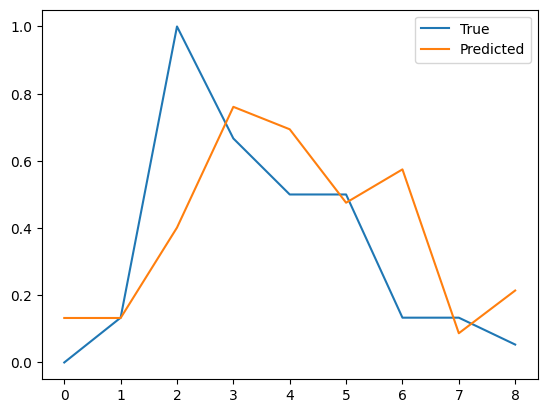

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 8198
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[ True  True  True ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
True values: [0.   0.   0.   0.   0.6  1.   0.45 0.2  0.2 ]
Predicted values: [0.13241813 0.13241813 0.13241813 0.13241813 0.13241813 0.81630564
 0.7652582  0.43740648 0.09192176]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
3               8198    1995-07-01             0       8198              29   
4               8198    1996-07-01             0       8198              29   
5               8198    1997-07-01             0       8198              29   
6               8198    1998-07-01             0       8198              29   
7               8198    2000-07-01             0       8198              29   
8          

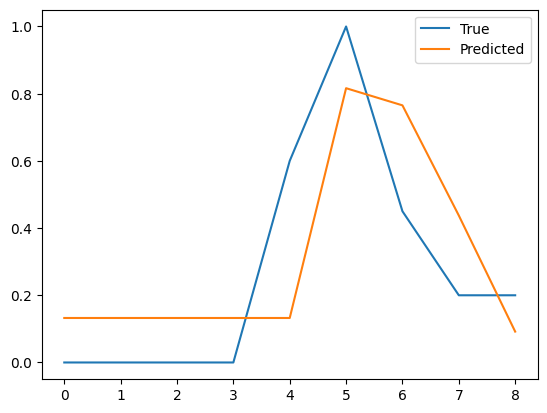

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 8198
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[ True  True  True ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
True values: [0.   0.   0.   0.   0.6  1.   0.45 0.2  0.2 ]
Predicted values: [0.13241813 0.13241813 0.13241813 0.13241813 0.13241813 0.81630564
 0.7652582  0.43740648 0.09192176]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
3               8198    1995-07-01             0       8198              29   
4               8198    1996-07-01             0       8198              29   
5               8198    1997-07-01             0       8198              29   
6               8198    1998-07-01             0       8198              29   
7               8198    2000-07-01             0       8198              29   
8          

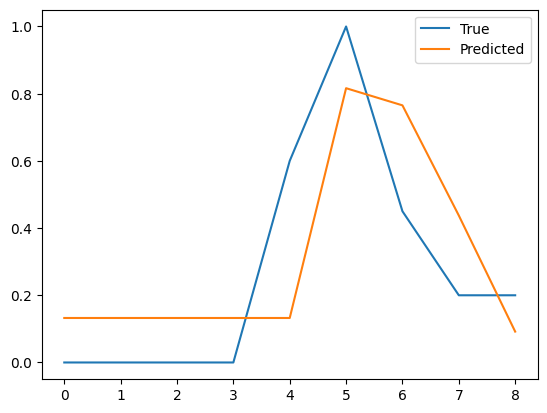

----------------xxxxx----------------


In [5]:
player_id = 28396
default_value = f"{player_id}"
user_input = default_value
while user_input.isdigit(): 
    user_input = input(f"Enter something (default: {default_value}).\n Enter any non-numeric value (eg:Stop) to stop predictions: ") or default_value
    if user_input.isdigit():
        pid = int(user_input)

    if pid not in df.transfermarkt_id.values:
        print("--------------------------------")
        print("Player ID not found in data. Please try another ID.")
        print("--------------------------------") 
        #exit()
    else:
        try:
            print("--------------------------------")
            print("Predicting for player ID:", pid)
            print("--------------------------------")
            print(np.array(player_index))
            mask = np.array(player_index)==pid
            print(mask)
            X_player = X[mask]
            y_true = y[mask]
            y_pred = model.predict(X_player)
            print("True values:", y_true)
            print("Predicted values:", y_pred.flatten())
            print("--------------------------------")
            selected_rows = df.loc[df['transfermarkt_id'] == pid]
            print("--------------------------------")
            print(selected_rows)
            print("--------------------------------")
            plt.plot(y_true, label='True')
            plt.plot(y_pred, label='Predicted')
            
            plt.legend()
            plt.show()
            print("----------------xxxxx----------------")
        except Exception as e:
            print("Error during prediction:", e)
            print("--------------------------------")
